In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imageio

In [2]:
vidpath = 'cat.mp4'

In [3]:
# prompt: load a single frame of a video file

def load_single_frame(video_path, frame_number):
  """Loads a single frame from a video file.

  Args:
    video_path: Path to the video file.
    frame_number: The frame number to load (0-indexed).

  Returns:
    A NumPy array representing the frame, or None if the frame
    number is invalid or the file cannot be opened.
  """
  try:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
      print(f"Error opening video file: {video_path}")
      return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if not 0 <= frame_number < total_frames:
      print(f"Invalid frame number: {frame_number}. Total frames: {total_frames}")
      return None

    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()

    if ret:
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    else:
        print(f"Error reading frame {frame_number}")
        return None
  except Exception as e:
    print(f"An error occurred: {e}")
    return None


(1080, 1920, 3)
Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).
Selected corners (row, col):
[[  92  330]
 [ 105 1516]
 [1045 1507]
 [1056  338]]


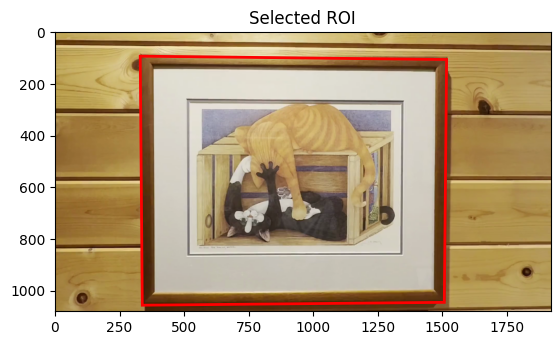

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load first frame
frame0 = load_single_frame(vidpath, 0)   # shape (H, W, 3),
print(frame0.shape)
# Prepare for interactive picking
points = []
def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
        points.append((x, y))
        # draw a small circle on click
        cv2.circle(frame_disp, (x, y), 5, (0, 255, 0), -1)

# Convert to BGR uint8 for cv2 display
frame_disp = cv2.cvtColor((frame0).astype('uint8'), cv2.COLOR_RGB2BGR)
win = "Select 4 corners: TL → TR → BR → BL"
cv2.namedWindow(win)
cv2.setMouseCallback(win, mouse_callback)

print("Click in the window to select TOP‑LEFT, TOP‑RIGHT, BOTTOM‑RIGHT, BOTTOM‑LEFT (in that order).")

# Show window and wait until 4 clicks
while True:
    cv2.imshow(win, frame_disp)
    if len(points) == 4:
        break
    # small delay so CPU isn’t pegged
    if cv2.waitKey(50) & 0xFF == 27:  # allow Esc to abort early
        break

cv2.destroyAllWindows()

# Convert collected (x,y) to (row, col) array
corners = np.array([[y, x] for (x, y) in points])  # shape (4,2)

print("Selected corners (row, col):")
print(corners)

# width = horizontal span (x‑axis = column index)
width  = int(max(abs(corners[1,1] - corners[0,1]),   # top edge
                 abs(corners[2,1] - corners[3,1])))  # bottom edge

# height = vertical span (y‑axis = row index)
height = int(max(abs(corners[3,0] - corners[0,0]),   # left edge
                 abs(corners[2,0] - corners[1,0])))  # right edge

rectcorners = np.array([[0, 0],
                        [0, width],
                        [height, width],
                        [height, 0]])


H0C, _ = cv2.findHomography(corners[:, ::-1],   # col,row order
                            rectcorners[:, ::-1],
                            cv2.RANSAC)

# visualize the region you picked
plt.imshow(frame0)
plt.fill(corners[:,1], corners[:,0],
         edgecolor='red', lw=2, facecolor='none')
plt.title("Selected ROI")
plt.show()


In [5]:
print("Homography from frame -> rectified: ", H0C)

Homography from frame -> rectified:  [[ 9.67012544e-01 -8.02500037e-03 -3.18375840e+02]
 [-1.07141596e-02  9.77461019e-01 -8.63907411e+01]
 [-2.07944226e-05 -1.47721403e-05  1.00000000e+00]]


In [6]:
# Rectify the Image
def rectify(img, incorners, outcorners):
  outsize = (outcorners[2, 1], outcorners[2, 0])
  H, m = cv2.findHomography(incorners[:,::-1], outcorners[:,::-1], cv2.RANSAC) # uses col,row order
  outimg = cv2.warpPerspective(img, H, outsize)
  return outimg

(964, 1186, 3)


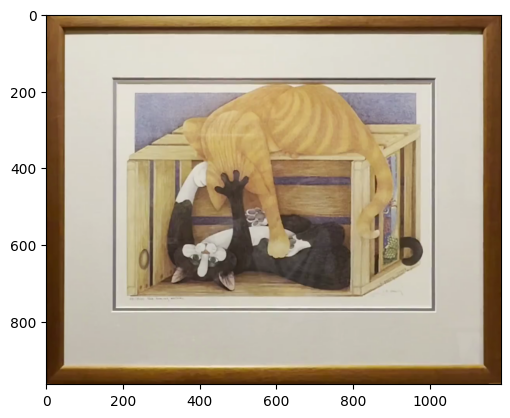

In [7]:
# show original rectified image
refimg = rectify(frame0, corners, rectcorners)
print(refimg.shape)
plt.imshow(refimg)
plt.show()

In [8]:
import sys, os, argparse
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf        
sys.path.append('../')

from data_read import *
from net import *

# ────────────────────────────── CLI ──────────────────────────────
parser = argparse.ArgumentParser()

parser.add_argument('--dataset_name',          dest='dataset_name',
                    default='MSCOCO',
                    help='MSCOCO, GoogleMap, GoogleEarth, DayNight')

parser.add_argument('--epoch_load_one',        dest='epoch_load_one',
                    type=int, default=3)
parser.add_argument('--epoch_load_two',        dest='epoch_load_two',
                    type=int, default=3)
parser.add_argument('--epoch_load_three',      dest='epoch_load_three',
                    type=int, default=3)

parser.add_argument('--num_iters',             dest='num_iters',
                    type=int, default=50)

parser.add_argument('--feature_map_type',      dest='feature_map_type',
                    default='special',          # <‑‑ only “special”
                    help='special')

parser.add_argument('--initial_type',          dest='initial_type',
                    default='multi_net',        # <‑‑ only “multi_net”
                    help='multi_net')

parser.add_argument('--load_epoch_multinet',   dest='load_epoch_multinet',
                    default=[50, 50, 40])

input_parameters = parser.parse_args([])

# ─────────────────────── GPU memory limit (optional) ───────────────────────
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)]
        )
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

# ─────────────────────────── Functions (unchanged) ─────────────────────────
def construct_matrix_regression(batch_size, network_output, network_output_2=[0]):
    extra = tf.ones((batch_size, 1))
    predicted_matrix = tf.concat([network_output, extra], axis=-1)
    predicted_matrix = tf.reshape(predicted_matrix, [batch_size, 3, 3])
    if len(np.shape(network_output_2)) > 1:
        predicted_matrix_2 = tf.concat([network_output_2, extra], axis=-1)
        predicted_matrix_2 = tf.reshape(predicted_matrix_2, [batch_size, 3, 3])
    hh_matrix = []
    for i in range(batch_size):
        if len(np.shape(network_output_2)) > 1:
            hh_matrix.append(np.linalg.inv(np.dot(predicted_matrix_2[i, :, :],
                                                  predicted_matrix[i, :, :])))
        else:
            hh_matrix.append(np.linalg.inv(predicted_matrix[i, :, :]))
    return np.asarray(hh_matrix)

def initial_motion_COCO():
    matrix_list = []
    for _ in range(1):
        src_points  = [[0, 0], [127, 0], [127, 127], [0, 127]]
        tgt_points  = [[32, 32], [160, 32], [160, 160], [32, 160]]
        src_points  = np.reshape(src_points, [4, 1, 2])
        tgt_points  = np.reshape(tgt_points, [4, 1, 2])
        h_matrix, _ = cv2.findHomography(src_points, tgt_points, 0)
        matrix_list.append(h_matrix)
    return np.asarray(matrix_list).astype(np.float32)

def construct_matrix(initial_matrix, scale_factor, batch_size):
    initial_matrix = tf.cast(initial_matrix, dtype=tf.float32)
    scale_matrix = np.eye(3) * scale_factor
    scale_matrix[2, 2] = 1.0
    scale_matrix = tf.cast(scale_matrix, dtype=tf.float32)
    scale_matrix_inverse = tf.linalg.inv(scale_matrix)
    scale_matrix = tf.expand_dims(scale_matrix, axis=0)
    scale_matrix = tf.tile(scale_matrix, [batch_size, 1, 1])
    scale_matrix_inverse = tf.expand_dims(scale_matrix_inverse, axis=0)
    scale_matrix_inverse = tf.tile(scale_matrix_inverse, [batch_size, 1, 1])
    return tf.matmul(tf.matmul(scale_matrix, initial_matrix), scale_matrix_inverse)

def average_cornner_error(batch_size, predicted_matrix, u_list, v_list,
                          top_left_u=0, top_left_v=0,
                          bottom_right_u=127, bottom_right_v=127):
    four_conner = [[top_left_u,      top_left_v,      1],
                   [bottom_right_u,  top_left_v,      1],
                   [bottom_right_u,  bottom_right_v,  1],
                   [top_left_u,      bottom_right_v,  1]]
    four_conner = np.asarray(four_conner).T
    four_conner = np.expand_dims(four_conner, axis=0)
    four_conner = np.tile(four_conner, [batch_size, 1, 1]).astype(np.float32)
    new_pts     = tf.matmul(predicted_matrix, four_conner)
    new_pts    /= new_pts[:, 2:, :]
    u_predict   = new_pts[:, 0, :]
    v_predict   = new_pts[:, 1, :]
    return tf.reduce_mean(tf.sqrt(tf.square(u_predict - u_list) +
                                  tf.square(v_predict - v_list)))

def calculate_feature_map(input_tensor):
    bs, height, width, channel = tf.shape(input_tensor)
    patches = tf.image.extract_patches(input_tensor,
                                       sizes=(1, 3, 3, 1),
                                       strides=(1, 1, 1, 1),
                                       rates=(1, 1, 1, 1),
                                       padding='SAME')
    patches = tf.reshape(patches, (bs, height, width, channel, 9))
    mean    = tf.reduce_mean(patches, axis=3, keepdims=True)
    patches = patches - mean
    patches_T = tf.transpose(patches, (0, 1, 2, 4, 3))
    var_mat   = tf.matmul(patches_T, patches)
    trace     = tf.linalg.trace(var_mat)
    row_sum   = tf.reduce_sum(var_mat, axis=-1)
    max_rs    = tf.reduce_max(row_sum, axis=-1)
    min_rs    = tf.reduce_min(row_sum, axis=-1)
    mimic_ratio = (max_rs + min_rs) / (2.0 * trace)
    return tf.expand_dims(mimic_ratio, axis=-1)

# ──────────────── Feature‑map networks (SPECIAL only) ───────────────
if input_parameters.feature_map_type != 'special':
    raise ValueError("Only 'special' feature_map_type is supported.")

load_path_one   = f'./checkpoints/{input_parameters.dataset_name}/level_one/'
load_path_two   = f'./checkpoints/{input_parameters.dataset_name}/level_two/'
load_path_three = f'./checkpoints/{input_parameters.dataset_name}/level_three/'

level_one_input     = ResNet_first_input()
level_one_template  = ResNet_first_template()
level_two_input     = ResNet_second_input()
level_two_template  = ResNet_second_template()
level_three_input   = ResNet_third_input()
level_three_template= ResNet_third_template()

level_one_input.load_weights(   load_path_one   + f'epoch_{input_parameters.epoch_load_one}input_full')
level_one_template.load_weights(load_path_one   + f'epoch_{input_parameters.epoch_load_one}template_full')
level_two_input.load_weights(   load_path_two   + f'epoch_{input_parameters.epoch_load_two}input_full')
level_two_template.load_weights(load_path_two   + f'epoch_{input_parameters.epoch_load_two}template_full')
level_three_input.load_weights( level_path_three:=load_path_three + f'epoch_{input_parameters.epoch_load_three}input_full')
level_three_template.load_weights(load_path_three + f'epoch_{input_parameters.epoch_load_three}template_full')

# ─────────────── Initialisation network (MULTI‑NET only) ───────────────
if input_parameters.initial_type != 'multi_net':
    raise ValueError("Only 'multi_net' initial_type is supported.")

save_path_one   = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_1/'
save_path_two   = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_2/'
save_path_three = f'./checkpoints/{input_parameters.dataset_name}/regression_stage_3/'

regression_network_one   = Net_first()
regression_network_two   = Net_second()
regression_network_three = Net_third()

regression_network_one.load_weights(  save_path_one   + f'epoch_{input_parameters.load_epoch_multinet[0]}')
regression_network_two.load_weights(  save_path_two   + f'epoch_{input_parameters.load_epoch_multinet[1]}')
regression_network_three.load_weights(save_path_three + f'epoch_{input_parameters.load_epoch_multinet[2]}')

# ──────────────── Lucas‑Kanade layers ────────────────
LK_layer_one   = Lucas_Kanade_layer(batch_size=1, height_template=128, width_template=128, num_channels=1)
LK_layer_two   = Lucas_Kanade_layer(batch_size=1, height_template=64,  width_template=64,  num_channels=1)
LK_layer_three = Lucas_Kanade_layer(batch_size=1, height_template=32,  width_template=32,  num_channels=1)
LK_layer_regression = Lucas_Kanade_layer(batch_size=1, height_template=192, width_template=192, num_channels=3)

# ─────────────────────── Data loaders ───────────────────────
if   input_parameters.dataset_name == 'MSCOCO':
    data_loader_caller = data_loader_MSCOCO('val')
elif input_parameters.dataset_name == 'GoogleMap':
    data_loader_caller = data_loader_GoogleMap('val')
elif input_parameters.dataset_name == 'GoogleEarth':
    data_loader_caller = data_loader_GoogleEarth('val')
elif input_parameters.dataset_name == 'DayNight':
    data_loader_caller = data_loader_DayNight('val')
else:
    raise ValueError('Unknown dataset name')


1 Physical GPUs, 1 Logical GPUs


2025-07-19 23:18:56.088595: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-07-19 23:18:56.088612: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-07-19 23:18:56.088617: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-07-19 23:18:56.088667: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-19 23:18:56.088849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


6387


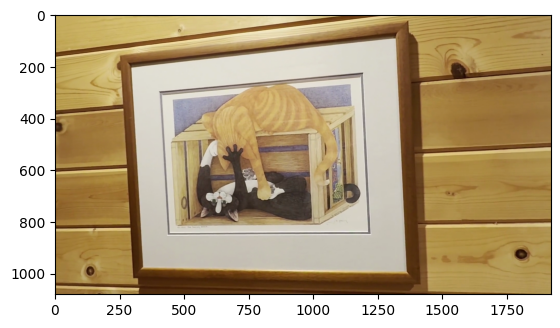

In [9]:
plt.imshow(load_single_frame(vidpath, 90))

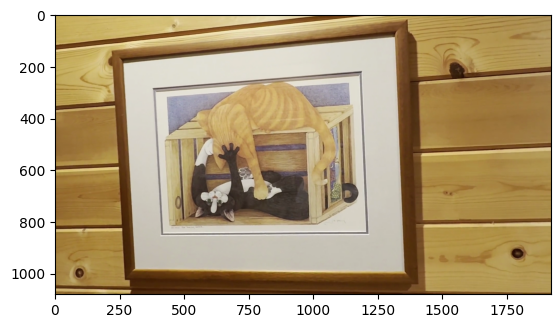

In [10]:
plt.imshow(load_single_frame(vidpath, 80))

Loaded original input image shape: (192, 192, 3)
Loaded original template image shape: (128, 128, 3)
Resized input image for feature extraction shape: (192, 192, 3)
Resized template image for feature extraction shape: (128, 128, 3)
Shape of prepared input for regression models: (1, 192, 192, 2)
39.46255320379879
tf.Tensor(
[[[5.0864587e+00 3.7825984e-01 1.6700394e+01]
  [1.5579866e+00 4.0358334e+00 5.0869101e-01]
  [2.0980040e-02 1.4202984e-02 1.0000000e+00]]], shape=(1, 3, 3), dtype=float32)


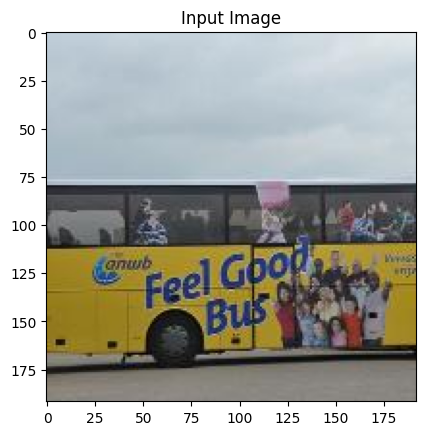

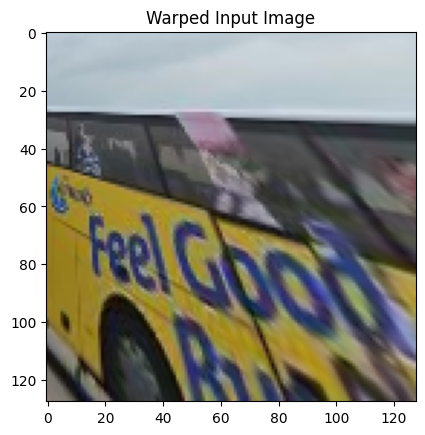

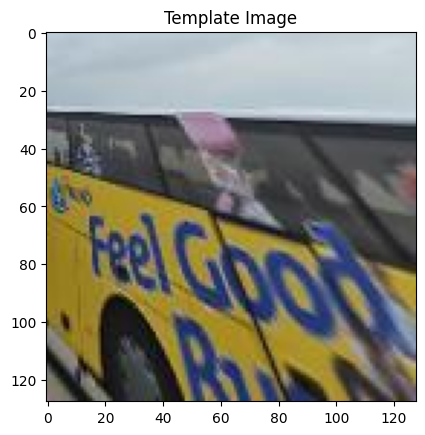

: 

In [ ]:
# Load and Initially Normalize Images (as done in data_read.py for MSCOCO)
frame1 = load_single_frame(vidpath, 60)
try:
    raw_input_img = plt.imread('input1.jpg') / 255.0
    raw_template_img = plt.imread('template1.jpg') /255.0
    # raw_input_img = load_single_frame(vidpath, 110) /255.0
    # raw_template_img = refimg/255.0
    print(f"Loaded original input image shape: {raw_input_img.shape}")
    print(f"Loaded original template image shape: {raw_template_img.shape}")

except FileNotFoundError:
    print("Error: One or both of the image files were not found. Please check the paths.")
    # You might want to exit here or handle the error gracefully
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading images: {e}")
    exit()
    
target_input_dim = (192, 192)
target_template_dim = (128, 128)

input_img_resized = resize(raw_input_img, target_input_dim, anti_aliasing=True)
template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

print(f"Resized input image for feature extraction shape: {input_img_resized.shape}")
print(f"Resized template image for feature extraction shape: {template_img_resized.shape}")

# Convert NumPy arrays to TensorFlow tensors and add a batch dimension (for a single image).
input_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(input_img_resized, dtype=tf.float32), axis=0)
template_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(template_img_resized, dtype=tf.float32), axis=0)

# Prepare Images for Initial Regression Network
template_img_padded_for_regression = tf.image.pad_to_bounding_box(template_img_tf_batch, 32, 32, 192, 192)

input_img_grey_for_regression = tf.image.rgb_to_grayscale(input_img_tf_batch)
template_img_grey_for_regression = tf.image.rgb_to_grayscale(template_img_padded_for_regression)

# This tensor is the direct input to the initial regression networks.
network_input_for_regression_models = tf.concat([template_img_grey_for_regression, input_img_grey_for_regression], axis=-1)

print(f"Shape of prepared input for regression models: {network_input_for_regression_models.shape}")

u_list_manual = np.array([[0, 127, 127, 0]]) 
v_list_manual = np.array([[0, 0, 127, 127]])


total_error = 0.0    
fk_loop = input_parameters.num_iters

# Loop runs only once for manual image processing
for iters in range(1):
    # Map your manually loaded images to the variables used in the original notebook.
    # input_img and template_img here are the RGB images with a batch dimension.
    input_img = input_img_tf_batch
    template_img = template_img_tf_batch
    # Use your manual u_list and v_list for error calculation.
    u_list = u_list_manual
    v_list = v_list_manual
    if input_parameters.initial_type=='simple_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)    
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector=regression_network.call(network_input,training=False)
        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)

    if input_parameters.initial_type=='multi_net':
        input_img_grey=tf.image.rgb_to_grayscale(input_img)
        template_img_new=tf.image.pad_to_bounding_box(template_img, 32, 32, 192, 192)  
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_one=regression_network_one.call(network_input,training=False)
        matrix_one=construct_matrix_regression(1,homography_vector_one)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_one)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new) 
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_two=regression_network_two.call(network_input,training=False)
        matrix_two=construct_matrix_regression(1,homography_vector_one,homography_vector_two)
        template_img_new=LK_layer_regression.projective_inverse_warp(tf.dtypes.cast(template_img,tf.float32), matrix_two)
        template_img_grey=tf.image.rgb_to_grayscale(template_img_new)  
        network_input=tf.concat([template_img_grey,input_img_grey],axis=-1)
        homography_vector_three=regression_network_three.call(network_input,training=False)

        extra=tf.ones((1,1))
        initial_matrix=tf.concat([homography_vector_three,extra],axis=-1)
        initial_matrix=tf.reshape(initial_matrix,[1,3,3])
        initial_matrix=np.dot(initial_matrix[0,:,:], np.linalg.inv(matrix_two[0,:,:]))
        initial_matrix=np.expand_dims(initial_matrix,axis=0)
        initial_matrix=construct_matrix(initial_matrix,scale_factor=0.25,batch_size=1)


        
    input_feature_one=level_one_input.call(input_img,training=False)
    template_feature_one=level_one_template.call(template_img,training=False)

    input_feature_two=level_two_input.call(input_feature_one,training=False)
    template_feature_two=level_two_template.call(template_feature_one,training=False)

    input_feature_three=level_three_input.call(input_feature_two,training=False)
    template_feature_three=level_three_template.call(template_feature_two,training=False)


    if input_parameters.feature_map_type=='regular':
        input_feature_map_one=input_feature_one
        template_feature_map_one=template_feature_one

        input_feature_map_two=input_feature_two
        template_feature_map_two=template_feature_two

        input_feature_map_three=input_feature_three
        template_feature_map_three=template_feature_three

    elif input_parameters.feature_map_type=='special':
                
        input_feature_map_one=calculate_feature_map(input_feature_one)
        template_feature_map_one=calculate_feature_map(template_feature_one)

        input_feature_map_two=calculate_feature_map(input_feature_two)
        template_feature_map_two=calculate_feature_map(template_feature_two)

        input_feature_map_three=calculate_feature_map(input_feature_three)
        template_feature_map_three=calculate_feature_map(template_feature_three)
        
        
    updated_matrix=initial_matrix
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_three.update_matrix(template_feature_map_three,input_feature_map_three,updated_matrix)
        except:
            print ('s')

    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_two.update_matrix(template_feature_map_two,input_feature_map_two,updated_matrix)
        except:
            print ('s')
            
    updated_matrix=construct_matrix(updated_matrix,scale_factor=2.0,batch_size=1)
    for j in range(fk_loop):
        try:
            updated_matrix=LK_layer_one.update_matrix(template_feature_map_one,input_feature_map_one,updated_matrix)
        except:
            print ('s')



    predicted_matrix=updated_matrix



    cornner_error=average_cornner_error(1,predicted_matrix,u_list,v_list,top_left_u=0,top_left_v=0,bottom_right_u=127,bottom_right_v=127)

    print(predicted_matrix)
    
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# 1. Get the dimensions of the template_img
template_height, template_width, _ = template_img[0].shape

# 2. Re-initialize LK_layer_regression with the template's dimensions
LK_layer_for_final_warp = Lucas_Kanade_layer(
    batch_size=1, # Keep batch size as 1
    height_template=template_height,
    width_template=template_width,
    num_channels=3
)


warped_input_img = LK_layer_for_final_warp.projective_inverse_warp(
    tf.dtypes.cast(input_img, tf.float32),
    predicted_matrix
)

plt.imshow((input_img[0, :, :, :] * 255).astype(np.uint8))
plt.title("Input Image")
plt.show()

# Display the warped input image
plt.imshow((warped_input_img[0, :, :, :].numpy() * 255).astype(np.uint8))
plt.title("Warped Input Image")
plt.show()

# Display the original template image
plt.imshow((template_img[0, :, :, :] * 255).astype(np.uint8))
plt.title("Template Image")
plt.show()

In [ ]:
import os
import cv2

# 1️⃣  Tensor → uint8 RGB
warped_np = (warped_input_img[0].numpy() * 255).astype(np.uint8)   # shape (H,W,3), RGB

# 2️⃣  RGB → BGR because cv2.imwrite expects BGR
warped_bgr = cv2.cvtColor(warped_np, cv2.COLOR_RGB2BGR)

# 3️⃣  Choose / create an output folder
out_dir = "warped_frames"
os.makedirs(out_dir, exist_ok=True)

# 4️⃣  Build a filename and save
out_path = os.path.join(out_dir, "frame1_warped_to_template.png")
cv2.imwrite(out_path, warped_bgr)

print(f"✓  Saved warped image to {out_path}")

In [12]:
def estimate_homography_pair(input_rgb: np.ndarray,
                             template_rgb: np.ndarray
                             ) -> np.ndarray:
    """
    Runs the full Deep‑LK pipeline once and returns the 3 × 3 homography
    (template ➜ input) as a NumPy array.

    Parameters
    ----------
    input_rgb      : np.ndarray  (H,W,3)  – frame k in [0‑255] or [0‑1]
    template_rgb   : np.ndarray  (H,W,3)  – canonical template (frame 0)
    target_input_dim,
    target_template_dim         – resize targets, keep default

    Returns
    -------
    H_pred : np.ndarray shape (3,3)  – homography TEMPLATE→INPUT
    """
    # ─────────────────── 1. normalise to 0‑1 & RGB ────────────────────────────
    raw_input_img    = input_rgb   / (255.0 if input_rgb.max() > 1.01 else 1.0)
    raw_template_img = template_rgb/ (255.0 if template_rgb.max() > 1.01 else 1.0)

    if raw_input_img.ndim == 2:      # greyscale safeguard
        raw_input_img = np.stack([raw_input_img]*3, axis=-1)
    if raw_template_img.ndim == 2:
        raw_template_img = np.stack([raw_template_img]*3, axis=-1)

    # ─────────────────── 2. resize exactly like notebook ──────────────────────
    input_img_resized    = resize(raw_input_img,    target_input_dim,    anti_aliasing=True)
    template_img_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

    input_img_tf_batch    = tf.expand_dims(tf.convert_to_tensor(input_img_resized,    tf.float32), 0)
    template_img_tf_batch = tf.expand_dims(tf.convert_to_tensor(template_img_resized, tf.float32), 0)

    # ─────────────────── 3. initial‑net preparation  ──────────────────────────
    template_img_padded_for_regression  = tf.image.pad_to_bounding_box(template_img_tf_batch,
                                                                       32, 32, 192, 192)
    input_img_grey_for_regression       = tf.image.rgb_to_grayscale(input_img_tf_batch)
    template_img_grey_for_regression    = tf.image.rgb_to_grayscale(template_img_padded_for_regression)
    network_input_for_regression_models = tf.concat(
        [template_img_grey_for_regression, input_img_grey_for_regression], axis=-1
    )

    # ─────────────────── 4. initial homography  (same branches) ───────────────
    if input_parameters.initial_type == 'simple_net':
        homography_vector = regression_network.call(network_input_for_regression_models,
                                                    training=False)
        extra = tf.ones((1, 1))
        initial_matrix = tf.concat([homography_vector, extra], axis=-1)
        initial_matrix = tf.reshape(initial_matrix, [1, 3, 3])
        initial_matrix = construct_matrix(initial_matrix, scale_factor=0.25, batch_size=1)

    elif input_parameters.initial_type == 'multi_net':
        # ‑‑ identical to your notebook, kept verbatim ‑‑
        input_img_grey    = tf.image.rgb_to_grayscale(input_img_tf_batch)
        template_img_new  = tf.image.pad_to_bounding_box(template_img_tf_batch, 32, 32, 192, 192)
        template_img_grey = tf.image.rgb_to_grayscale(template_img_new)
        network_input     = tf.concat([template_img_grey, input_img_grey], axis=-1)

        homography_vector_one  = regression_network_one.call(network_input, training=False)
        matrix_one             = construct_matrix_regression(1, homography_vector_one)
        template_img_new       = LK_layer_regression.projective_inverse_warp(
                                     tf.cast(template_img_tf_batch, tf.float32), matrix_one)

        template_img_grey = tf.image.rgb_to_grayscale(template_img_new)
        network_input      = tf.concat([template_img_grey, input_img_grey], axis=-1)
        homography_vector_two = regression_network_two.call(network_input, training=False)
        matrix_two            = construct_matrix_regression(
                                    1, homography_vector_one, homography_vector_two)

        template_img_new       = LK_layer_regression.projective_inverse_warp(
                                     tf.cast(template_img_tf_batch, tf.float32), matrix_two)

        template_img_grey = tf.image.rgb_to_grayscale(template_img_new)
        network_input      = tf.concat([template_img_grey, input_img_grey], axis=-1)
        homography_vector_three = regression_network_three.call(network_input, training=False)

        extra          = tf.ones((1, 1))
        initial_matrix = tf.concat([homography_vector_three, extra], axis=-1)
        initial_matrix = tf.reshape(initial_matrix, [1, 3, 3])
        initial_matrix = np.dot(initial_matrix[0], np.linalg.inv(matrix_two[0]))
        initial_matrix = np.expand_dims(initial_matrix, 0)
        initial_matrix = construct_matrix(initial_matrix, scale_factor=0.25, batch_size=1)
    else:
        raise ValueError("Unknown initial_type")

    # ─────────────────── 5. feature pyramids ──────────────────────────────────
    input_feature_one     = level_one_input.call(input_img_tf_batch,    training=False)
    template_feature_one  = level_one_template.call(template_img_tf_batch, training=False)
    input_feature_two     = level_two_input.call(input_feature_one,     training=False)
    template_feature_two  = level_two_template.call(template_feature_one, training=False)
    input_feature_three   = level_three_input.call(input_feature_two,   training=False)
    template_feature_three= level_three_template.call(template_feature_two, training=False)

    # choose map type
    if input_parameters.feature_map_type == 'special':
        input_feature_map_one     = calculate_feature_map(input_feature_one)
        template_feature_map_one  = calculate_feature_map(template_feature_one)
        input_feature_map_two     = calculate_feature_map(input_feature_two)
        template_feature_map_two  = calculate_feature_map(template_feature_two)
        input_feature_map_three   = calculate_feature_map(input_feature_three)
        template_feature_map_three= calculate_feature_map(template_feature_three)
    else:  # 'regular'
        input_feature_map_one     = input_feature_one
        template_feature_map_one  = template_feature_one
        input_feature_map_two     = input_feature_two
        template_feature_map_two  = template_feature_two
        input_feature_map_three   = input_feature_three
        template_feature_map_three= template_feature_three

    # ─────────────────── 6. three‑level Lucas‑Kanade refinement ───────────────
    fk_loop       = input_parameters.num_iters
    updated_matrix = initial_matrix  # start

    # level 3 (coarsest)
    for _ in range(fk_loop):
        updated_matrix = LK_layer_three.update_matrix(template_feature_map_three,
                                                      input_feature_map_three,
                                                      updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)

    # level 2
    for _ in range(fk_loop):
        updated_matrix = LK_layer_two.update_matrix(template_feature_map_two,
                                                    input_feature_map_two,
                                                    updated_matrix)
    updated_matrix = construct_matrix(updated_matrix, scale_factor=2.0, batch_size=1)

    # level 1 (finest)
    for _ in range(fk_loop):
        updated_matrix = LK_layer_one.update_matrix(template_feature_map_one,
                                                    input_feature_map_one,
                                                    updated_matrix)

    # ─────────────────── 7. result ────────────────────────────────────────────
    H_pred = updated_matrix[0].numpy()  # (3,3)

    return H_pred


In [ ]:
frame_k = load_single_frame(vidpath, 111)

In [ ]:
H_0k    = estimate_homography_pair(frame_k, frame0)
print(H_0k)

In [13]:
import os, cv2, tensorflow as tf, numpy as np
from pathlib import Path
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# ───────────────────────── SET‑UP ──────────────────────────
vidpath  = "cat.mp4"             # ← change this
out_dir  = Path("warped_frames")        # where PNGs are written
out_dir.mkdir(parents=True, exist_ok=True)

# 0) canonical template (frame 0) – keep in RAM
frame0 =refimg
templ_h, templ_w = frame0.shape[:2]

def tensor_to_uint8(img_tf):
    """Convert single‑image tensor [H,W,3] float32 0‑1 → uint8 RGB."""
    img_np = img_tf.numpy()
    if img_np.max() <= 1.01:
        img_np *= 255.0
    return img_np.clip(0,255).astype("uint8")

# ────────────────────── MAIN LOOP ──────────────────────────
cap = cv2.VideoCapture(vidpath)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames in video: {total_frames}")

for k in range(1, total_frames, 5):
    # 1) load frame k ----------------------------------------------------------
    frame_k = load_single_frame(vidpath, k)           # RGB (H,W,3)

    # 2) estimate H(frame0 ➜ frame_k) -------------------------------------------------
    H_pred = estimate_homography_pair(frame_k, frame0)   # 3×3 numpy

    # 3) build a *fresh* LK layer for this warp --------------------------------
    LK_layer_for_final_warp = Lucas_Kanade_layer(
        batch_size    = 1,
        height_template = templ_h,
        width_template  = templ_w,
        num_channels    = 3
    )

    # 4) warp frame_k back to canonical view -----------------------------------
    input_img_tf = tf.convert_to_tensor(frame_k / 255.0
                                        if frame_k.max() > 1.01 else frame_k,
                                        tf.float32)[None, ...]         # add batch dim

    warped_tf = LK_layer_for_final_warp.projective_inverse_warp(
                    input_img_tf,
                    tf.convert_to_tensor(H_pred, tf.float32)[None, ...] )

    warped_uint8 = tensor_to_uint8(warped_tf[0])        # drop batch dim

    # 5) save PNG --------------------------------------------------------------
    out_path = out_dir / f"warped_{k:04d}.png"
    cv2.imwrite(str(out_path), cv2.cvtColor(warped_uint8, cv2.COLOR_RGB2BGR))
    print(f"✓ saved {out_path}")

cap.release()
print("All done.")


Total frames in video: 249
✓ saved warped_frames/warped_0001.png
✓ saved warped_frames/warped_0006.png
✓ saved warped_frames/warped_0011.png
✓ saved warped_frames/warped_0016.png
✓ saved warped_frames/warped_0021.png
✓ saved warped_frames/warped_0026.png
✓ saved warped_frames/warped_0031.png
✓ saved warped_frames/warped_0036.png
✓ saved warped_frames/warped_0041.png
✓ saved warped_frames/warped_0046.png
✓ saved warped_frames/warped_0051.png
✓ saved warped_frames/warped_0056.png
✓ saved warped_frames/warped_0061.png
✓ saved warped_frames/warped_0066.png
✓ saved warped_frames/warped_0071.png
✓ saved warped_frames/warped_0076.png
✓ saved warped_frames/warped_0081.png
✓ saved warped_frames/warped_0086.png
✓ saved warped_frames/warped_0091.png
✓ saved warped_frames/warped_0096.png
✓ saved warped_frames/warped_0101.png
✓ saved warped_frames/warped_0106.png
✓ saved warped_frames/warped_0111.png
✓ saved warped_frames/warped_0116.png
✓ saved warped_frames/warped_0121.png
✓ saved warped_frames/w

In [ ]:
import cv2
import glob
import os

# ── 1. Collect and sort the image paths ────────────────────────────────────────
img_dir   = "warped_frames"
pattern   = os.path.join(img_dir, "*.png")        # change to *.jpg if needed
img_paths = sorted(glob.glob(pattern))            # ensures 0001,0002,0003…

if not img_paths:
    raise FileNotFoundError(f"No images found with pattern: {pattern}")

print(f"Found {len(img_paths)} warped frames")

# ── 2. Peek at first frame to get dimensions ───────────────────────────────────
first_img  = cv2.imread(img_paths[0])             # BGR
h, w, _    = first_img.shape

# ── 3. Configure the video writer ─────────────────────────────────────────────
out_path   = "warped_sequence.mp4"
fps        = 30                                   # choose any fps you like
fourcc     = cv2.VideoWriter_fourcc(*"mp4v")      # or "avc1" if mp4v isn't available
writer     = cv2.VideoWriter(out_path, fourcc, fps, (w, h))

# ── 4. Write frames to the video ──────────────────────────────────────────────
for idx, path in enumerate(img_paths):
    frame = cv2.imread(path)                      # BGR
    if frame is None:
        print(f"⚠️  Skipping unreadable file: {path}")
        continue
    if frame.shape[0:2] != (h, w):
        # resize if any frame differs (unlikely if they all came from the same pipeline)
        frame = cv2.resize(frame, (w, h))
    writer.write(frame)
    if idx % 50 == 0:
        print(f"Added frame {idx + 1}/{len(img_paths)}")

writer.release()
print("✓  Video written to", out_path)


In [ ]:
# ───────────────────────── IMPORTS & CONSTANTS ──────────────────────────────
import os, cv2, numpy as np, tensorflow as tf
from pathlib import Path
from skimage.transform import resize
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# Deep‑LK training crop sizes (do NOT change unless you retrain)
target_input_dim    = (192, 192)   # (H, W)
target_template_dim = (128, 128)   # (H, W)

# ───────────────────────── 1. HOMOGRAPHY ESTIMATOR ──────────────────────────
def estimate_homography_pair(input_rgb: np.ndarray,
                             template_rgb: np.ndarray) -> np.ndarray:
    """
    Returns H_T→I in the **192‑pixel coordinate system** (template ➜ input).
    """
    # 1) normalise to 0‑1 floats ------------------------------------------------
    raw_input_img    = input_rgb.astype(np.float32) / (255.0 if input_rgb.max() > 1.01 else 1.0)
    raw_template_img = template_rgb.astype(np.float32) / (255.0 if template_rgb.max() > 1.01 else 1.0)

    if raw_input_img.ndim == 2:      # greyscale safeguard
        raw_input_img = np.stack([raw_input_img]*3, axis=-1)
    if raw_template_img.ndim == 2:
        raw_template_img = np.stack([raw_template_img]*3, axis=-1)

    # 2) resize exactly like training -----------------------------------------
    input_resized    = resize(raw_input_img,    target_input_dim,    anti_aliasing=True)
    template_resized = resize(raw_template_img, target_template_dim, anti_aliasing=True)

    input_tf    = tf.expand_dims(tf.convert_to_tensor(input_resized,    tf.float32), 0)
    template_tf = tf.expand_dims(tf.convert_to_tensor(template_resized, tf.float32), 0)

    # 3) prepare regression stacks --------------------------------------------
    template_pad = tf.image.pad_to_bounding_box(template_tf, 32, 32, 192, 192)
    net_in = tf.concat(
        [tf.image.rgb_to_grayscale(template_pad),
         tf.image.rgb_to_grayscale(input_tf)], axis=-1)

    # 4) initial homography (simple_net or multi_net) --------------------------
    if input_parameters.initial_type == 'simple_net':
        homog_vec = regression_network(net_in, training=False)
        initial   = tf.reshape(tf.concat([homog_vec, tf.ones((1,1))], -1), [1,3,3])
        initial   = construct_matrix(initial, scale_factor=0.25, batch_size=1)

    elif input_parameters.initial_type == 'multi_net':
        # --- first regression round ------------------------------------------
        input_grey    = tf.image.rgb_to_grayscale(input_tf)
        template_pad  = tf.image.pad_to_bounding_box(template_tf, 32, 32, 192, 192)
        template_grey = tf.image.rgb_to_grayscale(template_pad)
        net_in        = tf.concat([template_grey, input_grey], -1)

        hv1      = regression_network_one(net_in,  training=False)
        M1       = construct_matrix_regression(1, hv1)
        template_new = LK_layer_regression.projective_inverse_warp(
                           tf.cast(template_tf, tf.float32), M1)

        # --- second ----------------------------------------------------------
        template_grey = tf.image.rgb_to_grayscale(template_new)
        net_in        = tf.concat([template_grey, input_grey], -1)
        hv2           = regression_network_two(net_in, training=False)
        M2            = construct_matrix_regression(1, hv1, hv2)

        template_new  = LK_layer_regression.projective_inverse_warp(
                            tf.cast(template_tf, tf.float32), M2)

        # --- third -----------------------------------------------------------
        template_grey = tf.image.rgb_to_grayscale(template_new)
        net_in        = tf.concat([template_grey, input_grey], -1)
        hv3           = regression_network_three(net_in, training=False)

        initial = tf.reshape(tf.concat([hv3, tf.ones((1,1))], -1), [1,3,3])
        initial = tf.expand_dims(
                      tf.linalg.matmul(initial[0], tf.linalg.inv(M2[0])), 0)
        initial = construct_matrix(initial, scale_factor=0.25, batch_size=1)
    else:
        raise ValueError("Unknown initial_type")

    # 5) feature pyramids ------------------------------------------------------
    f1_i = level_one_input(input_tf,       training=False)
    f1_t = level_one_template(template_tf, training=False)
    f2_i = level_two_input(f1_i,           training=False)
    f2_t = level_two_template(f1_t,        training=False)
    f3_i = level_three_input(f2_i,         training=False)
    f3_t = level_three_template(f2_t,      training=False)

    if input_parameters.feature_map_type == 'special':
        fmap1_i, fmap1_t = calculate_feature_map(f1_i), calculate_feature_map(f1_t)
        fmap2_i, fmap2_t = calculate_feature_map(f2_i), calculate_feature_map(f2_t)
        fmap3_i, fmap3_t = calculate_feature_map(f3_i), calculate_feature_map(f3_t)
    else:  # regular
        fmap1_i, fmap1_t = f1_i, f1_t
        fmap2_i, fmap2_t = f2_i, f2_t
        fmap3_i, fmap3_t = f3_i, f3_t

    # 6) 3‑level Lucas‑Kanade refinement --------------------------------------
    fk_loop = input_parameters.num_iters
    H = initial

    for _ in range(fk_loop):     # level‑3
        H = LK_layer_three.update_matrix(fmap3_t, fmap3_i, H)
    H = construct_matrix(H, scale_factor=2.0, batch_size=1)

    for _ in range(fk_loop):     # level‑2
        H = LK_layer_two.update_matrix(fmap2_t, fmap2_i, H)
    H = construct_matrix(H, scale_factor=2.0, batch_size=1)

    for _ in range(fk_loop):     # level‑1
        H = LK_layer_one.update_matrix(fmap1_t, fmap1_i, H)

    return H[0].numpy()          # H_T→I   in 192‑px coords
# ─────────────────────────────────────────────────────────────────────────────


# ───────────────────────── 2. VIDEO‑FRAME WARPING ───────────────────────────
vidpath   = "cat.mp4"           # <‑‑ change
out_dir   = Path("warped_frames")
out_dir.mkdir(parents=True, exist_ok=True)

# canonical template (frame 0)
rectimg   = load_single_frame(vidpath, 0)   # RGB, full resolution
templ_h, templ_w = rectimg.shape[:2]

# global LK layer (re‑used each frame)
LK_warper = Lucas_Kanade_layer(
    batch_size      = 1,
    height_template = templ_h,
    width_template  = templ_w,
    num_channels    = 3
)

def tensor_to_uint8(img_tf):
    """[1,H,W,3] or [H,W,3] float32 in 0‑1 → uint8 RGB (H,W,3)."""
    img_np = img_tf.numpy()
    if img_np.ndim == 4:
        img_np = img_np[0]
    if img_np.max() <= 1.01:
        img_np *= 255.0
    return img_np.clip(0,255).astype("uint8")

# helpers for scale conversion (192‑px ↔ full res)
S_up   = np.array([[templ_w/target_input_dim[1], 0, 0],
                   [0, templ_h/target_input_dim[0], 0],
                   [0, 0, 1]], dtype=np.float32)
S_down = np.linalg.inv(S_up)

# ───────────────────────── MAIN LOOP ────────────────────────────────
cap = cv2.VideoCapture(vidpath)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Total frames:", total_frames)

for k in range(1, total_frames):
    frame_k = load_single_frame(vidpath, k)             # RGB
    H_T2I_192 = estimate_homography_pair(frame_k, rectimg)

    # --- convert to full‑res and invert --------------------------------------
    H_T2I_full = S_up @ H_T2I_192 @ S_down        # 192‑px → full res
    H_I2T_full = np.linalg.inv(H_T2I_full)        # need INPUT → TEMPLATE

    # --- warp ---------------------------------------------------------------
    inp_tf = tf.convert_to_tensor(frame_k.astype(np.float32)/255.0, tf.float32)[None, ...]
    warped_tf = LK_warper.projective_inverse_warp(inp_tf,
                    tf.convert_to_tensor(H_I2T_full, tf.float32)[None, ...])

    warped_u8 = tensor_to_uint8(warped_tf)
    cv2.imwrite(str(out_dir / f"warped_{k:04d}.png"),
                cv2.cvtColor(warped_u8, cv2.COLOR_RGB2BGR))
    print(f"✓ frame {k}/{total_frames-1}")

cap.release()
print("All done – warped PNGs saved in", out_dir)


Total frames: 249
✓ frame 1/248
✓ frame 2/248
✓ frame 3/248
✓ frame 4/248
✓ frame 5/248
✓ frame 6/248
✓ frame 7/248
✓ frame 8/248
✓ frame 9/248
✓ frame 10/248
✓ frame 11/248
✓ frame 12/248
✓ frame 13/248
✓ frame 14/248
✓ frame 15/248
✓ frame 16/248
✓ frame 17/248
✓ frame 18/248
✓ frame 19/248
✓ frame 20/248
✓ frame 21/248
✓ frame 22/248
✓ frame 23/248
✓ frame 24/248
✓ frame 25/248
✓ frame 26/248
✓ frame 27/248
✓ frame 28/248
✓ frame 29/248
✓ frame 30/248
✓ frame 31/248
✓ frame 32/248
✓ frame 33/248
✓ frame 34/248
✓ frame 35/248
✓ frame 36/248
✓ frame 37/248
✓ frame 38/248
✓ frame 39/248
✓ frame 40/248
✓ frame 41/248
✓ frame 42/248
✓ frame 43/248
✓ frame 44/248
✓ frame 45/248
✓ frame 46/248
✓ frame 47/248
✓ frame 48/248
✓ frame 49/248
✓ frame 50/248
✓ frame 51/248
✓ frame 52/248
✓ frame 53/248
✓ frame 54/248
✓ frame 55/248
✓ frame 56/248
✓ frame 57/248
✓ frame 58/248
✓ frame 59/248
✓ frame 60/248
✓ frame 61/248
✓ frame 62/248
✓ frame 63/248
✓ frame 64/248
✓ frame 65/248
✓ frame 66/248
✓

Notes to myself:
- works for some pairs of images
- not every pair works
- why does frame 150 work?

In [14]:
# --- Stand‑alone cell: save every frame in a video --------------------------
import cv2
import os
from pathlib import Path

# ▶️ 1.  Fill in your paths
vidpath      = "cat.mp4"      #  ← original video
output_dir   = "frames_original_video"       #  ← where frames will be saved

# ▶️ 2.  Make sure the output directory exists
Path(output_dir).mkdir(parents=True, exist_ok=True)

# ▶️ 3.  Open the video & query its properties
cap = cv2.VideoCapture(vidpath)
if not cap.isOpened():
    raise FileNotFoundError(f"Could not open video at {vidpath}")

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"Total frames detected: {total_frames}")

# ▶️ 4.  Loop through the video and write each frame
frame_idx = 0
while True:
    success, frame_bgr = cap.read()
    if not success:
        break                        # reached the end

    # Optional: convert BGR→RGB before saving with cv2.imwrite (not required)
    # frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)

    fname = f"frame_{frame_idx:06d}.png"      # zero‑padded names
    cv2.imwrite(os.path.join(output_dir, fname), frame_bgr)
    
    frame_idx += 1
    if frame_idx % 100 == 0:
        print(f"Saved {frame_idx}/{total_frames} frames…")

cap.release()
print(f"✅  Done! {frame_idx} frames written to “{output_dir}”.")


Total frames detected: 249
Saved 100/249 frames…
Saved 200/249 frames…
✅  Done! 249 frames written to “frames_original_video”.
